In [1]:
import os, sys
import pathlib
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

Running on Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)], Tensorflow 2.5.0.


In [2]:
# Data loading
seed = 69
AUTOTUNE = tf.data.AUTOTUNE
tf.random.set_seed(seed)
np.random.seed(seed)

data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():  # Download data
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

labels = np.array(tf.io.gfile.listdir(str(data_dir)))
labels = labels[labels != 'README.md']
print('Commands:', labels)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/labels[0]))))
print('Example file tensor:', filenames[0])

train_files = filenames[:round(num_samples*0.8)]  # first 80%
val_files = filenames[round(num_samples*0.8): round(num_samples*0.8) + round(num_samples*0.1)]  # 80% to 90%
test_files = filenames[-round(num_samples*0.1):]  # last 10 %

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\right\\b25b6065_nohash_0.wav', shape=(), dtype=string)
Training set size 6400
Validation set size 800
Test set size 800


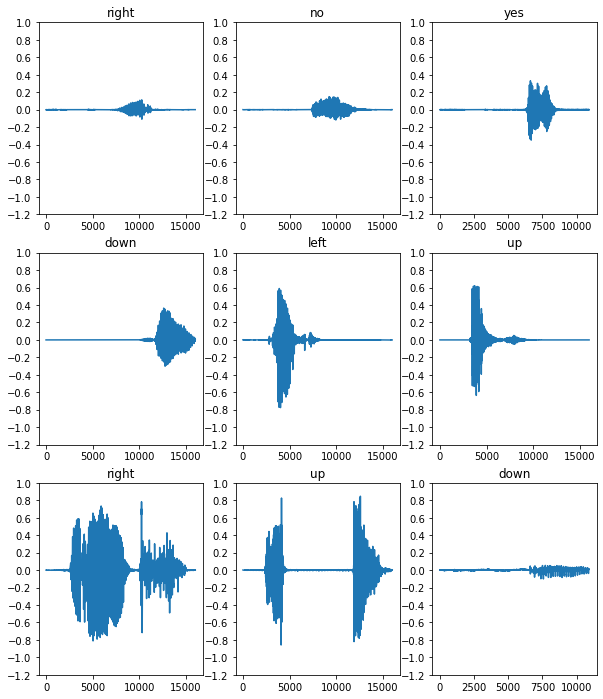

Label: right
Waveform shape: (16000,)
Spectrogram shape (make this square): (129, 129)
Audio playback


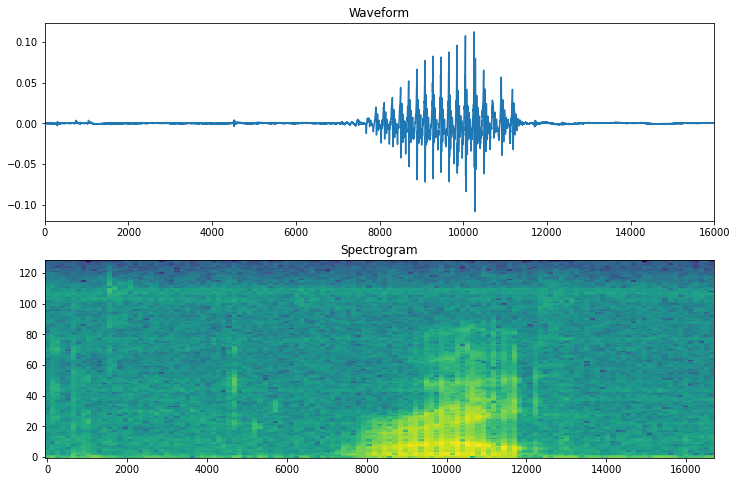

<ipython-input-3-b114d14c564c>:64: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


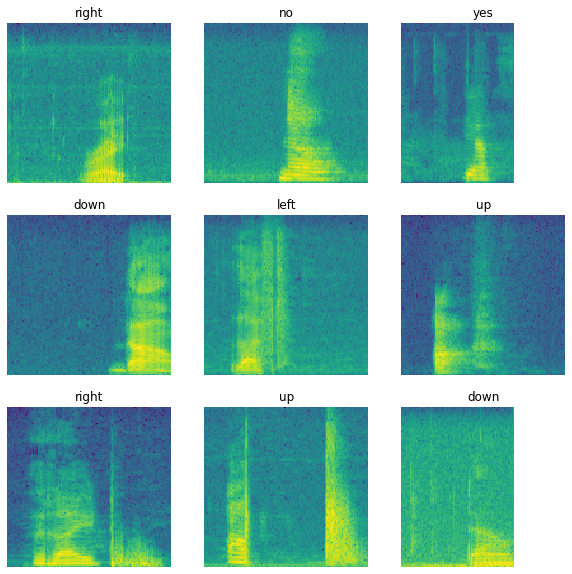

In [3]:
def get_waveform_and_label(file_path):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
    waveform = tf.squeeze(audio, axis=-1)
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    return waveform, label

train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

def plot_multiple_waveform(ds):
    rows = 3
    cols = 3
    n = rows*cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
    for i, (audio, label) in enumerate(ds.take(n)):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      ax.plot(audio.numpy())
      ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
      label = label.numpy().decode('utf-8')
      ax.set_title(label)
    plt.show()

plot_multiple_waveform(train_ds)

def plot_multiple_spectrogram(ds):
    rows = 3
    cols = 3
    n = rows*cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, (spectrogram, label_id) in enumerate(ds.take(n)):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
      ax.set_title(labels[label_id.numpy()])
      ax.axis('off')
    plt.show()

def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square.
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=123)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

for waveform, label in train_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape (make this square):', spectrogram.shape)
    img_height, img_width = spectrogram.shape
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

def plot_spectrogram(spectrogram, ax):
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec, shading='auto')

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  # spectrogram = tf.image.grayscale_to_rgb(spectrogram)  # RGB if using pretrained network that is trained on RGB images e.g. ImageNet, else can gray scale
  label_id = tf.argmax(label == labels)
  return spectrogram, label_id

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = train_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
plot_multiple_spectrogram(train_ds)

In [4]:
# Training
batch_size = 64
train_ds = train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

input_shape = (img_height, img_width, 1)
print('Input shape:', input_shape)
num_labels = len(labels)
norm_layer = Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

xInput = layers.Input(input_shape)
x = Resizing(64, 64)(xInput)
x = norm_layer(x)
x = Conv2D(64, 3)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = Conv2D(128, 3)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = Conv2D(256, 3)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
xOutput = Dense(num_labels)(x)  # no activation as using logits for loss

model = Model(xInput, xOutput)
model.summary()

Input shape: (129, 129, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 129, 129, 1)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None

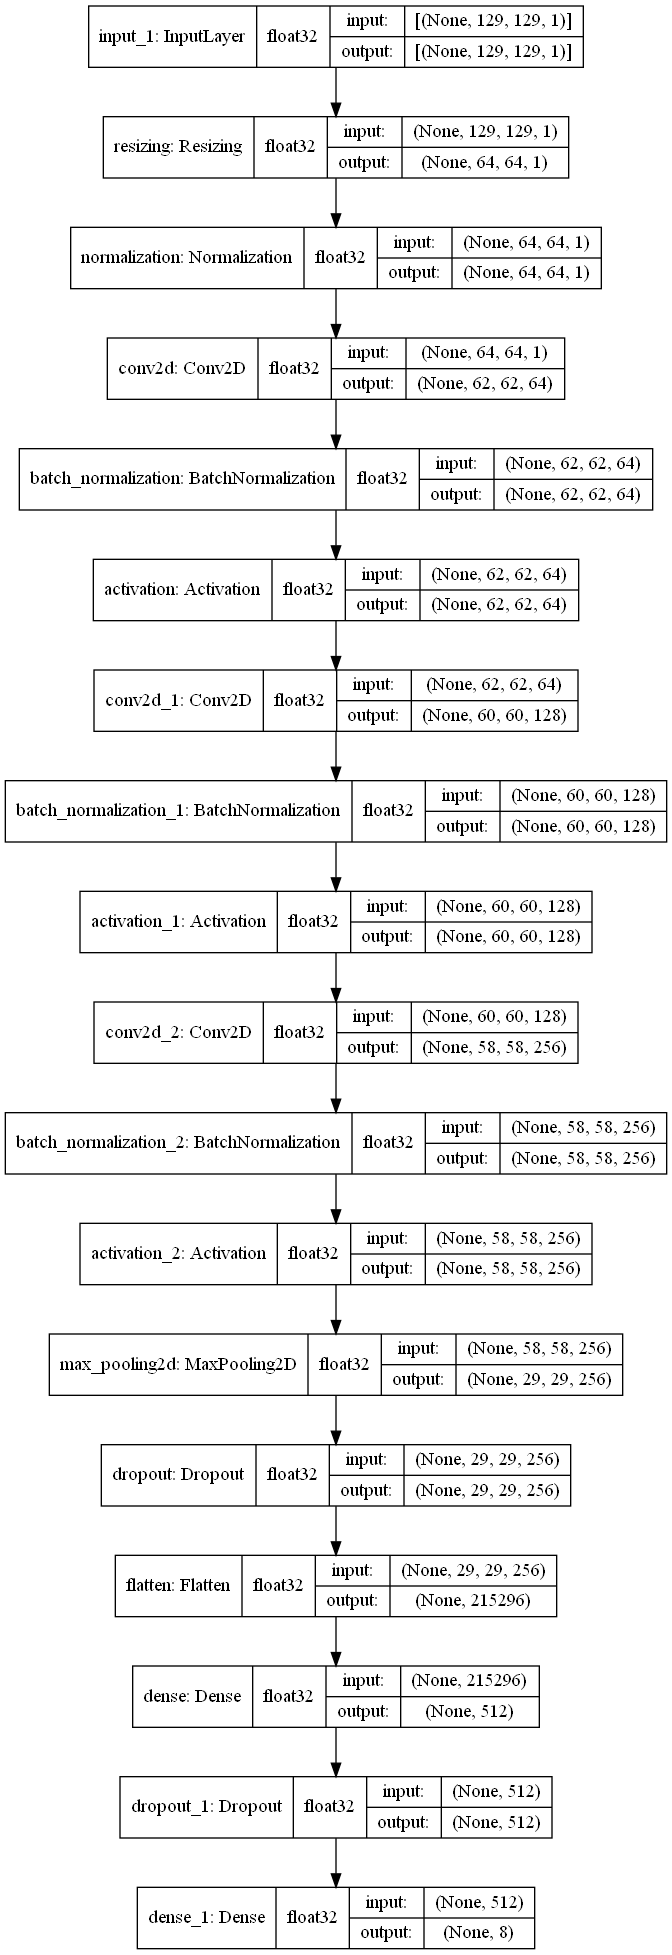

In [5]:
opt = keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-6)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
epoch = 100
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, verbose=1)
]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='audio_model.png')

In [6]:
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks, use_multiprocessing=True, verbose=1)

Epoch 1/100
100/100 [==============================] - 12s 87ms/step - loss: 3.4554 - accuracy: 0.1684 - val_loss: 2.0721 - val_accuracy: 0.1488

In [7]:
model.evaluate(test_ds)
model.save('mini_voice_classification')

13/13 [==============================] - 1s 54ms/step - loss: 0.3721 - accuracy: 0.8763
INFO:tensorflow:Assets written to: mini_voice_classification\assets


data\mini_speech_commands\down\0e5193e6_nohash_1.wav


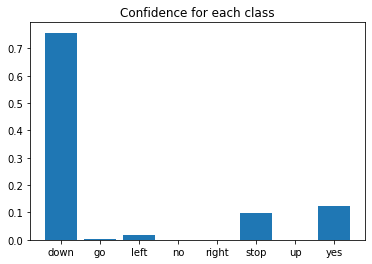

True label: down, Predicted label: down, confidence level: 75.77436%

data\mini_speech_commands\right\cd7f8c1b_nohash_4.wav


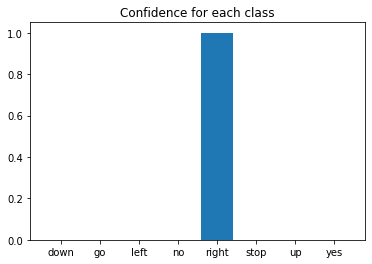

True label: right, Predicted label: right, confidence level: 99.99964%

data\mini_speech_commands\stop\f9f9751d_nohash_0.wav


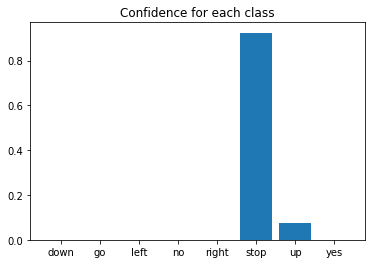

True label: stop, Predicted label: stop, confidence level: 92.47618%

data\mini_speech_commands\go\d78858d9_nohash_1.wav


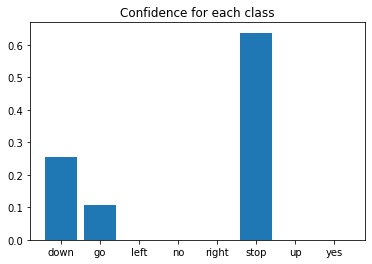

True label: go, Predicted label: stop, confidence level: 63.75814%

data\mini_speech_commands\go\94de6a6a_nohash_1.wav


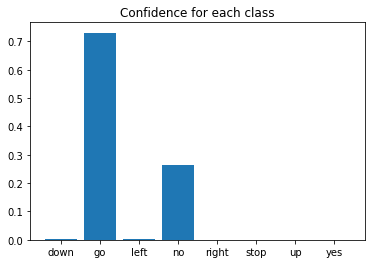

True label: go, Predicted label: go, confidence level: 73.08078%

data\mini_speech_commands\left\105a0eea_nohash_0.wav


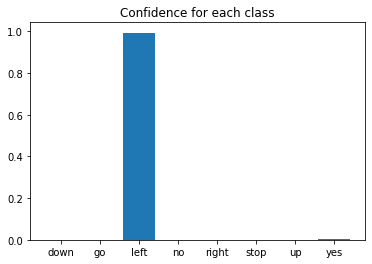

True label: left, Predicted label: left, confidence level: 99.38295%

data\mini_speech_commands\yes\39a12648_nohash_1.wav


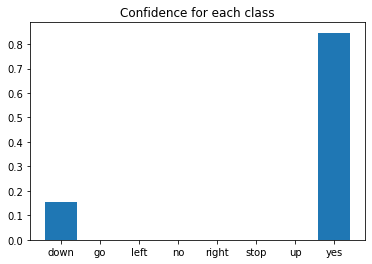

True label: yes, Predicted label: yes, confidence level: 84.63235%

data\mini_speech_commands\go\23abe1c9_nohash_1.wav


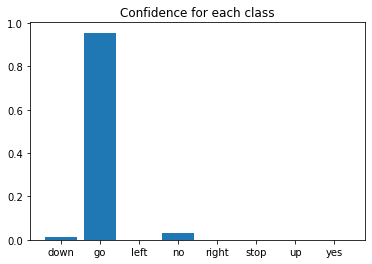

True label: go, Predicted label: go, confidence level: 95.54726%

data\mini_speech_commands\left\66041c69_nohash_0.wav


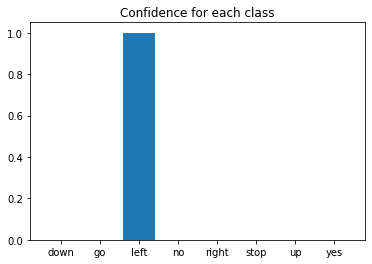

True label: left, Predicted label: left, confidence level: 99.98434%

data\mini_speech_commands\right\c93d5e22_nohash_4.wav


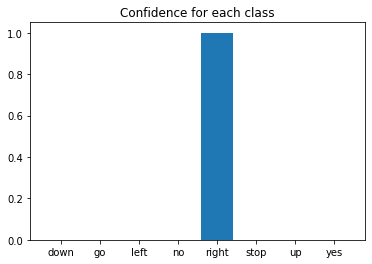

True label: right, Predicted label: right, confidence level: 100.0%



In [8]:
# Prediction
model = models.load_model('mini_voice_classification')
files_to_predict = [file.decode('utf-8') for file in test_files[:10].numpy()]
# files_to_predict = [data_dir/'stop/0ff728b5_nohash_4.wav', data_dir/'yes/2aec99ec_nohash_0.wav']
to_predict_ds = preprocess_dataset(list(map(str, files_to_predict)))
i = 0
for spectrogram, label in to_predict_ds.batch(1):
    print(files_to_predict[i])
    display.display(display.Audio(files_to_predict[i]))
    prediction = model(spectrogram)
    prediction_value = tf.nn.softmax(prediction[0]).numpy()
    plt.bar(labels, prediction_value)  # need to softmax raw prediction because model does not include softmax
    plt.title(f'Confidence for each class')
    plt.show()
    print(f'True label: {labels[label[0]]}, Predicted label: {labels[np.argmax(prediction_value)]}, confidence level: {round(np.amax(prediction_value) * 100, 5)}%\n')
    i+=1
